In [1]:
from pathlib import Path
import os

# Set project root = parent of /notebooks
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUT_DIR = ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

print("ROOT:", ROOT)
print("OUT_DIR:", OUT_DIR)


ROOT: C:\Users\parth\OneDrive\Desktop\mvtec_defect_detection
OUT_DIR: C:\Users\parth\OneDrive\Desktop\mvtec_defect_detection\outputs


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import cv2


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"  # change if needed
CATEGORIES = ["bottle", "cable", "hazelnut"]
IMG_SIZE = 224
BATCH_SIZE = 32


In [5]:
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


In [6]:
import os
import random
from collections import Counter


In [7]:
DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
CATEGORIES = ["bottle", "cable", "hazelnut"]

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    if not os.path.exists(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

samples = []
for cat in CATEGORIES:
    cat_path = os.path.join(DATASET_PATH, cat)

    # good images (label 0)
    good_dir = os.path.join(cat_path, "train", "good")
    for p in list_images(good_dir):
        samples.append((p, 0, cat, "good"))

    # defect images (label 1)
    test_dir = os.path.join(cat_path, "test")
    for defect_type in os.listdir(test_dir):
        sub = os.path.join(test_dir, defect_type)
        if defect_type == "good" or (not os.path.isdir(sub)):
            continue
        for p in list_images(sub):
            samples.append((p, 1, cat, defect_type))

random.seed(42)
random.shuffle(samples)

val_ratio = 0.2
val_size = int(len(samples) * val_ratio)
val_samples = samples[:val_size]
train_samples = samples[val_size:]

print("Train:", len(train_samples), " Val:", len(val_samples))
print("Train label counts:", dict(Counter([s[1] for s in train_samples])))
print("Val label counts:", dict(Counter([s[1] for s in val_samples])))


Train: 840  Val: 209
Train label counts: {0: 653, 1: 187}
Val label counts: {0: 171, 1: 38}


In [8]:
from PIL import Image
import torch
from torch.utils.data import Dataset

class MVTecBinaryDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, cat, subtype = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long), cat, subtype


In [9]:
from torchvision import transforms

IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [10]:
train_ds = MVTecBinaryDataset(train_samples, transform=train_tfms)
val_ds   = MVTecBinaryDataset(val_samples,   transform=val_tfms)

print("Train ds:", len(train_ds))
print("Val ds:", len(val_ds))


Train ds: 840
Val ds: 209


In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 27
Val batches: 7


Batch shape: torch.Size([32, 3, 224, 224])
First 10 labels: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
First 5 categories: ['cable', 'hazelnut', 'cable', 'bottle', 'cable']
First 5 subtypes: ['good', 'good', 'poke_insulation', 'good', 'good']


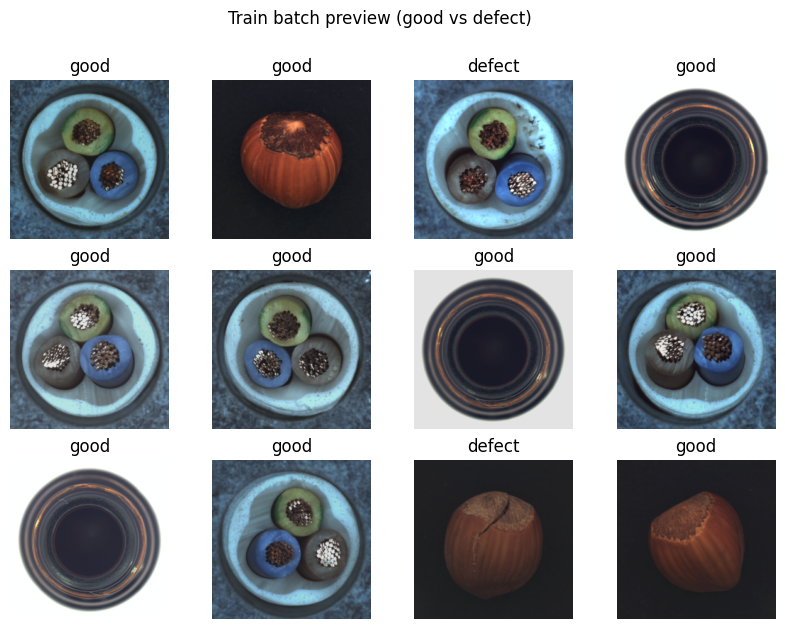

In [12]:
import matplotlib.pyplot as plt
import numpy as np

imgs, labels, cats, subtypes = next(iter(train_loader))

print("Batch shape:", imgs.shape)
print("First 10 labels:", labels[:10].tolist())
print("First 5 categories:", list(cats[:5]))
print("First 5 subtypes:", list(subtypes[:5]))

# unnormalize for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(10, 7))
for i in range(12):
    img = imgs[i].cpu().numpy().transpose(1, 2, 0)
    img = (img * std + mean)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title("defect" if labels[i].item() == 1 else "good")
    plt.axis("off")
plt.suptitle("Train batch preview (good vs defect)")
plt.show()


In [13]:
import torch
import torch.nn as nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: good vs defect
model = model.to(device)

model.eval()
print("Model created")


Device: cuda
Model created


In [14]:
import os

ckpt_path = os.path.join("outputs", "resnet18_mvtec_good_vs_defect_ft_layer4.pth")

print("Looking for:", os.path.abspath(ckpt_path))
print("Exists:", os.path.exists(ckpt_path))

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)

model.eval()
print("Loaded trained weights")


Looking for: C:\Users\parth\OneDrive\Desktop\mvtec_defect_detection\notebooks\outputs\resnet18_mvtec_good_vs_defect_ft_layer4.pth
Exists: True
Loaded trained weights


In [15]:
imgs, labels, cats, subtypes = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    logits = model(imgs)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

print("Preds first 10:", preds[:10].cpu().tolist())
print("True  first 10:", labels[:10].cpu().tolist())
print("Probs first 3 [good, defect]:\n", probs[:3].cpu().numpy())
print("Cats first 5:", list(cats[:5]))
print("Subtypes first 5:", list(subtypes[:5]))


Preds first 10: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
True  first 10: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Probs first 3 [good, defect]:
 [[9.8891115e-01 1.1088865e-02]
 [9.9931335e-01 6.8669184e-04]
 [9.9283147e-01 7.1685491e-03]]
Cats first 5: ['bottle', 'hazelnut', 'bottle', 'hazelnut', 'cable']
Subtypes first 5: ['good', 'good', 'good', 'good', 'good']


In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Pick target conv layer in ResNet18
target_layer = model.layer4[-1].conv2

activations = None
gradients = None

def forward_hook(module, inp, out):
    global activations
    activations = out

def full_backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Register hooks (ONLY these two)
_ = target_layer.register_forward_hook(forward_hook)
_ = target_layer.register_full_backward_hook(full_backward_hook)

print("Grad-CAM hooks registered on:", target_layer)


Grad-CAM hooks registered on: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


Sample: bottle good | true = 0 | pred = 0


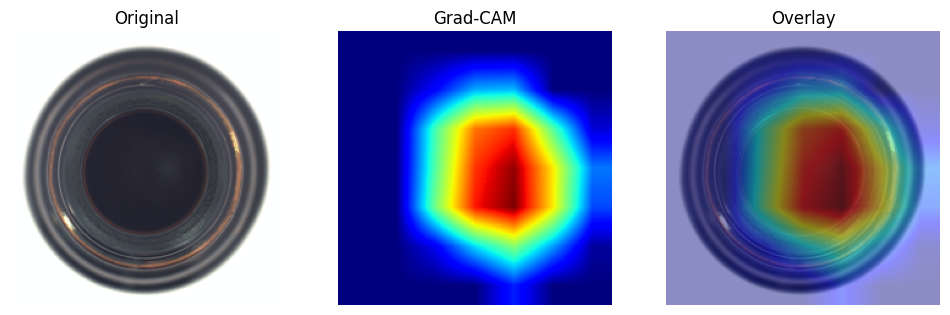

In [17]:
# Take one batch
imgs, labels, cats, subtypes = next(iter(val_loader))
imgs = imgs.to(device)
labels = labels.to(device)

# Choose one image index from the batch
idx = 0

model.zero_grad()
logits = model(imgs)

# choose class index = predicted class for that sample
pred_class = logits[idx].argmax()
score = logits[idx, pred_class]

score.backward()

# activations: [B, C, H, W] typically H=W=7 for ResNet18
act = activations[idx].detach()          # [C, 7, 7]
grad = gradients[idx].detach()           # [C, 7, 7]

# Global average pool gradients -> weights
weights = grad.mean(dim=(1, 2))          # [C]
cam = (weights[:, None, None] * act).sum(dim=0)   # [7, 7]
cam = F.relu(cam)

# Normalize and upsample to image size
cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)
cam = cam.cpu().numpy()
cam = cv2.resize(cam, (224, 224))        # FIXES your 7x7 vs 224x224 problem

# Convert input tensor back to displayable image (unnormalize)
img = imgs[idx].detach().cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
img = (img * std + mean)
img = np.clip(img, 0, 1)

# Heatmap + overlay
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

overlay = (0.55 * img + 0.45 * heatmap)
overlay = overlay / overlay.max()

print("Sample:", cats[idx], subtypes[idx], "| true =", labels[idx].item(), "| pred =", pred_class.item())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.show()


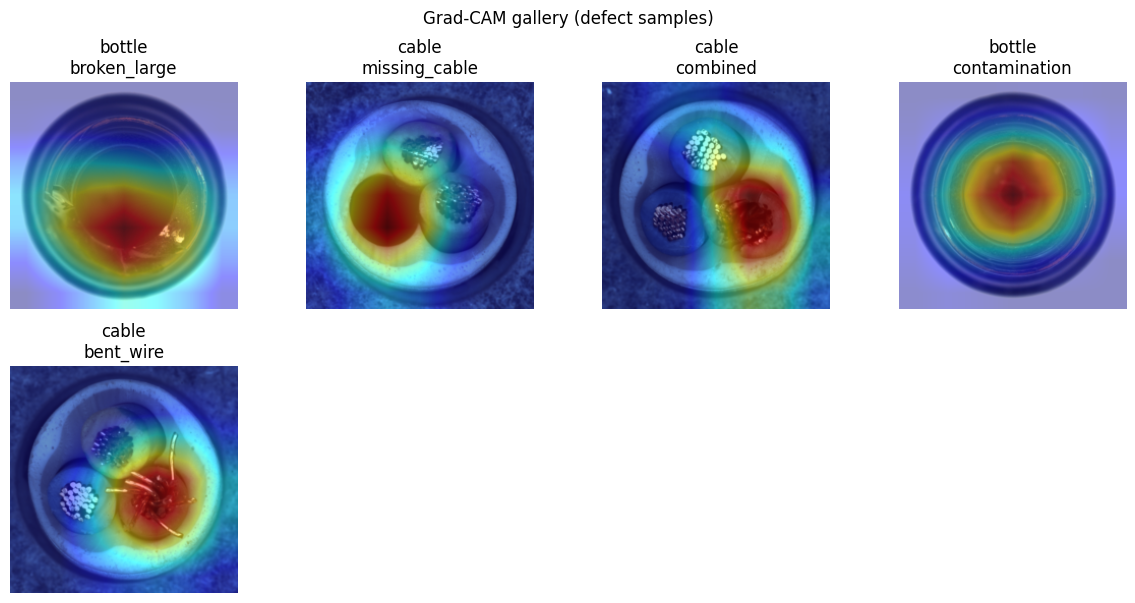

Saved: outputs\gradcam_gallery.png


In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

os.makedirs("outputs", exist_ok=True)

def make_gradcam_for_batch(imgs, labels, cats, subtypes, pick_defects_only=True, max_items=12):
    model.eval()
    results = []

    # move to device once
    imgs = imgs.to(device)
    labels = labels.to(device)

    # forward
    logits = model(imgs)

    # choose predicted class per sample
    preds = logits.argmax(dim=1)

    for i in range(imgs.size(0)):
        if pick_defects_only and labels[i].item() != 1:
            continue

        # compute Grad-CAM for this sample i
        model.zero_grad(set_to_none=True)
        score = logits[i, preds[i]]
        score.backward(retain_graph=True)

        # activations: [B, C, 7, 7], gradients: [B, C, 7, 7]
        act = activations[i].detach()          # [C, 7, 7]
        grad = gradients[i].detach()           # [C, 7, 7]

        weights = grad.mean(dim=(1, 2))        # [C]
        cam = (weights[:, None, None] * act).sum(dim=0)   # [7, 7]
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.detach().cpu().numpy()

        cam = cv2.resize(cam, (224, 224))

        # unnormalize image to HWC float [0,1]
        img = imgs[i].detach().cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        overlay = 0.55 * img + 0.45 * heatmap
        overlay = overlay / (overlay.max() + 1e-8)

        results.append((overlay, cats[i], subtypes[i], labels[i].item(), preds[i].item()))

        if len(results) >= max_items:
            break

    return results

# Take one batch from val_loader and build gallery from defect samples
imgs, labels, cats, subtypes = next(iter(val_loader))
gallery = make_gradcam_for_batch(imgs, labels, cats, subtypes, pick_defects_only=True, max_items=12)

plt.figure(figsize=(12, 9))
for k, (overlay, cat, subtype, y, p) in enumerate(gallery):
    plt.subplot(3, 4, k + 1)
    plt.imshow(overlay)
    plt.title(f"{cat}\n{subtype}")
    plt.axis("off")

plt.suptitle("Grad-CAM gallery (defect samples)")
plt.tight_layout()
out_path = os.path.join("outputs", "gradcam_gallery.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path)


In [19]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels, _, _ in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["good", "defect"], digits=4))


Confusion Matrix:
[[171   0]
 [  6  32]]

Classification Report:
              precision    recall  f1-score   support

        good     0.9661    1.0000    0.9828       171
      defect     1.0000    0.8421    0.9143        38

    accuracy                         0.9713       209
   macro avg     0.9831    0.9211    0.9485       209
weighted avg     0.9723    0.9713    0.9703       209



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch

def eval_with_threshold(th=0.4):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels, _, _ in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]  # defect probability
            preds = (probs >= th).long()

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    print("Threshold:", th)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["good","defect"], digits=4))

for th in [0.2, 0.3, 0.4, 0.5, 0.6]:
    eval_with_threshold(th)
    print("-"*50)


Threshold: 0.2
[[171   0]
 [  2  36]]
              precision    recall  f1-score   support

        good     0.9884    1.0000    0.9942       171
      defect     1.0000    0.9474    0.9730        38

    accuracy                         0.9904       209
   macro avg     0.9942    0.9737    0.9836       209
weighted avg     0.9905    0.9904    0.9903       209

--------------------------------------------------
Threshold: 0.3
[[171   0]
 [  6  32]]
              precision    recall  f1-score   support

        good     0.9661    1.0000    0.9828       171
      defect     1.0000    0.8421    0.9143        38

    accuracy                         0.9713       209
   macro avg     0.9831    0.9211    0.9485       209
weighted avg     0.9723    0.9713    0.9703       209

--------------------------------------------------
Threshold: 0.4
[[171   0]
 [  6  32]]
              precision    recall  f1-score   support

        good     0.9661    1.0000    0.9828       171
      defect     1.00

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.makedirs("outputs/misclassified", exist_ok=True)

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

model.eval()
idx = 0

with torch.no_grad():
    for imgs, labels, cats, subtypes in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(imgs.size(0)):
            if preds[i] != labels[i]:
                img = imgs[i].detach().cpu().numpy().transpose(1,2,0)
                img = img * std + mean
                img = np.clip(img, 0, 1)

                title = f"true={labels[i].item()} pred={preds[i].item()} p_def={probs[i,1].item():.3f}\n{cats[i]} {subtypes[i]}"
                plt.figure(figsize=(4,4))
                plt.imshow(img)
                plt.title(title)
                plt.axis("off")

                out = f"outputs/misclassified/mis_{idx:03d}.png"
                plt.savefig(out, dpi=200, bbox_inches="tight")
                plt.close()
                idx += 1

print("Saved misclassified images:", idx)


Saved misclassified images: 6


In [22]:
import os
from collections import Counter
import torch

model.eval()

errors = []  # (cat, subtype, true, pred, p_def)

with torch.no_grad():
    for imgs, labels, cats, subtypes in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1]  # defect probability
        preds = (probs >= 0.5).long()

        for i in range(imgs.size(0)):
            if preds[i].item() != labels[i].item():
                errors.append((cats[i], subtypes[i], labels[i].item(), preds[i].item(), float(probs[i].item())))

print("Total errors:", len(errors))

print("\nTop error categories:")
print(Counter([e[0] for e in errors]))

print("\nTop error subtypes (for defects only):")
print(Counter([e[1] for e in errors if e[2] == 1]))

print("\nAll errors:")
for e in errors:
    print(e)


Total errors: 6

Top error categories:
Counter({'cable': 3, 'hazelnut': 3})

Top error subtypes (for defects only):
Counter({'print': 3, 'cut_inner_insulation': 1, 'bent_wire': 1, 'cable_swap': 1})

All errors:
('cable', 'cut_inner_insulation', 1, 0, 0.2955206036567688)
('cable', 'bent_wire', 1, 0, 0.2045561671257019)
('hazelnut', 'print', 1, 0, 0.01383119449019432)
('hazelnut', 'print', 1, 0, 0.21249689161777496)
('cable', 'cable_swap', 1, 0, 0.005648774094879627)
('hazelnut', 'print', 1, 0, 0.20907776057720184)
